# MWE of PCH: Periodic deblurring problem

First import packages required

In [1]:
import sys

sys.path.append("..") 
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
import inspect

# Set rng seed 
np.random.seed(0)

Then import tools needed from CUQIpy:

In [2]:
from cuqi.testproblem import Deconvolution1D
from cuqi.model import LinearModel
from cuqi.distribution import Gaussian, Laplace_diff, Cauchy_diff
from cuqi.sampler import CWMH
from cuqi.problem import BayesianProblem
from cuqi.samples import Samples

## 1. Loading the Deconvolution problem

We want to experiment with the Deconvolution test problem; we first take a look at how to call it:

In [3]:
help(Deconvolution1D)

Help on class Deconvolution1D in module cuqi.testproblem._testproblem:

class Deconvolution1D(cuqi.problem._problem.BayesianProblem)
 |  Deconvolution1D(dim=128, kernel='gauss', kernel_param=None, phantom='gauss', phantom_param=None, noise_type='gaussian', noise_std=0.05, prior=None, data=None)
 |  
 |  1D periodic deconvolution test problem
 |  
 |  Parameters
 |  ------------
 |  dim : int
 |      size of the (dim,dim) deconvolution problem
 |  
 |  kernel : string or ndarray
 |      Determines type of the underlying kernel
 |      'Gauss' - a Gaussian function
 |      'sinc' or 'prolate' - a sinc function
 |      'vonMises' - a periodic version of the Gauss function
 |      ndarray - a custom kernel.
 |  
 |  kernel_param : scalar
 |      A parameter that determines the shape of the kernel;
 |      the larger the parameter, the slower the initial
 |      decay of the singular values of A.
 |      Ignored if kernel is a ndarray.
 |  
 |  phantom : string or ndarray
 |      The phanto

Specify parameters and create Deconvolution TestProblem:

In [4]:
dim = 128
kernel = ["Gauss","Sinc","vonMises"]
phantom = ["Gauss","Sinc","vonMises","Square","Hat","Bumps","DerivGauss"]
noise_type = ["Gaussian","ScaledGaussian"]
noise_std = 0.05

# Test problem
prob = Deconvolution1D(
    dim = dim,
    kernel=kernel[0],
    phantom=phantom[3],
    noise_type=noise_type[0],
    noise_std = noise_std
)

c:\Users\Nicolai\anaconda3\envs\pytorch3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


A CUQI TestProblem already contains everything apart from a prior to do UQ, so we could simply specify a prior and then run the UQ method directly on the test problem. This is because TestProblem is a subclass of BayesianProblem, so the UQ method is inherited. But, here we will "unpack" the main ingredients (the linear operator and the original clean signal) and build our problem from scratch.

In [5]:
A = prob.model.get_matrix()
phantom = prob.exactSolution     # We may later return and generate phantom as a sample from a prior distribution.

We can show the matrix and the "original clean signal" directly using python matplotlib plotting methods:

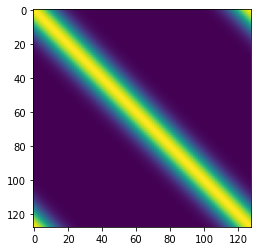

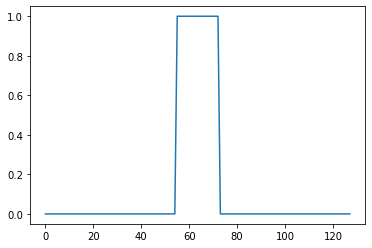

In [6]:
plt.figure()
plt.imshow(A)
plt.figure()
plt.plot(phantom)

## 2. Set up problem in CUQIpy with IID Gaussian prior

We first set up a CUQI LinearModel:

In [7]:
# Define as linear model
model = LinearModel(A)

With the CUQI model we can for example apply it to the clean signal and obtain clean data and plot it:

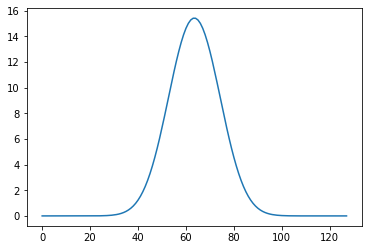

In [8]:
data_clean = model(phantom)
plt.plot(data_clean)

We can use the geometries of the domain and range of the model for the dedicated plot type (for a simple 1D signal like this, the default Continuous1D geometry is automatically employed and its plotting method simply add the xlabel)

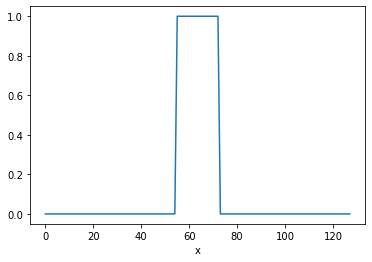

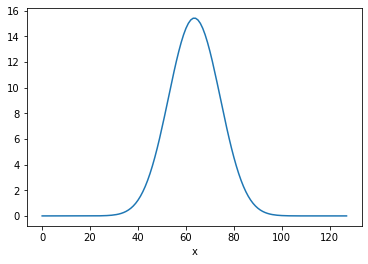

In [9]:
model.domain_geometry.plot(phantom)
plt.figure()
model.range_geometry.plot(data_clean)

Define data distribution as Gaussian with model as mean and i.i.d. noise with 0.05 std.  Note how the CUQIpy object "model" is given as the mean. Thus data distribution is a conditional distribution, which can only be sampled once the conditioning variable is specified.

In [10]:
noise_std = 0.05
data_dist = Gaussian(model, noise_std, np.eye(dim))

Generate and plot samples of noise by conditioning on the zero image:

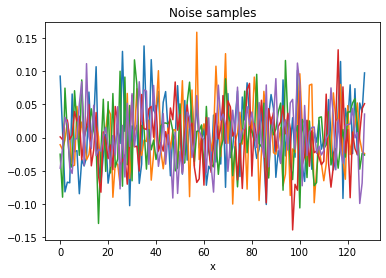

In [12]:
data_dist(np.zeros(dim)).sample(5).plot()
plt.title('Noise samples'); plt.show()

In the same way, by conditioning on the true phantom, we generate (noisy) samples of simulated data:

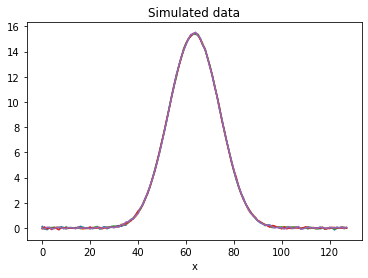

In [13]:
data_dist(phantom).sample(5).plot()
plt.title('Simulated data'); plt.show()

Now generate single realization of data to be used in inverse problem:

In [14]:
data = data_dist(phantom).sample()

Specify the prior distribution and generate and plot 5 samples:

c:\Users\Nicolai\anaconda3\envs\pytorch3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


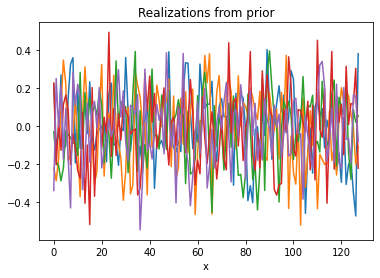

In [15]:
prior_std = 0.2
prior = Gaussian(np.zeros(dim), prior_std, np.eye(dim), name="x") # Set name to "x" to match model input

# Plot samples of prior
prior.sample(5).plot()
plt.title('Realizations from prior'); plt.show()

Combine likelihood, prior and the observed data into "BayesianProblem" object representing the inverse problem. No solving yet.

In [16]:
likelihood = data_dist.to_likelihood(data)

IP = BayesianProblem(likelihood, prior)

## 3. Solving the inverse problem

We can ask for the MAP estimate:  (for small fully Gaussian problems we use analytical expression; for more complicated problems support is underway using numerical optimization. Prototype support implemented at hackathon using gradients of logpdf and LBFGS from scipy)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct MAP of Gaussian posterior. Only works for small-scale problems with dim<=2000.


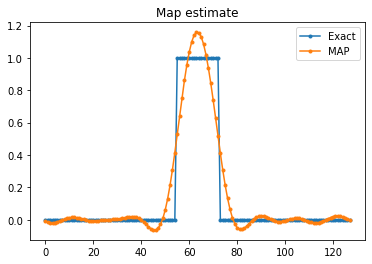

In [17]:
x_MAP = IP.MAP() 

# Plot
plt.plot(phantom,'.-')
plt.plot(x_MAP,'.-')
plt.title("Map estimate")
plt.legend(["Exact","MAP"])
plt.show()

Instead of MAP, we can sample the posterior:

In [18]:
Ns = 5000   # Number of samples
result = IP.sample_posterior(Ns)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct sampling of Gaussian posterior. Only works for small-scale problems with dim<=2000.
 Sample 5000 / 5000
Elapsed time: 0.15800166130065918


The output is a cuqi.Samples object containing the samples and various utilities such as plotting methods:

In [19]:
type(result)

cuqi.samples._samples.Samples

For example we can plot credibility interval around the exact:

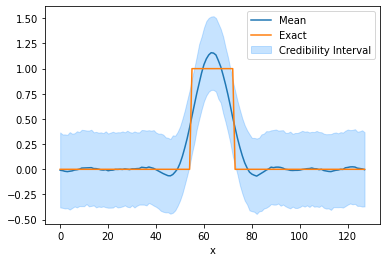

In [20]:
result.plot_ci(95, exact=phantom)

And the posterior sample std:

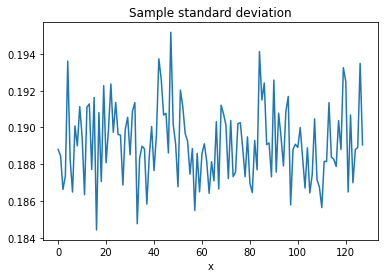

In [21]:
result.plot_std()

As well as chains of the individual parameters, here three shown:

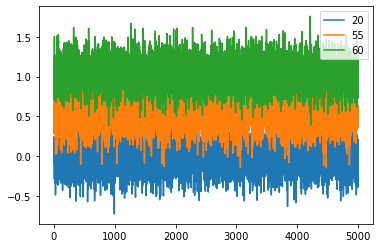

In [22]:
idx = [20,55,60]
result.plot_chain(idx)
plt.legend(idx)

Diagnostics of the sampling is ongoing work, some information is available currently in result:

In [23]:
result.diagnostics()

Geweke test passed at indices  (array([ 19,  28,  47,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  76,  77,  91,  95,  96, 111], dtype=int64),) 

Geweke test NOT passed at indices  (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  20,  21,  22,  23,  24,  25,  26,
        27,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  48,  49,  50,  75,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  92,  93,  94,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127], dtype=int64),) 



c:\Users\Nicolai\Desktop\CUQIpy\demos\..\cuqi\diagnostics.py:88: RuntimeWarning: divide by zero encountered in true_divide
  f = 1/(n*idx2)
c:\Users\Nicolai\Desktop\CUQIpy\demos\..\cuqi\diagnostics.py:41: UserWarning: Geweke's diagnostics is a work-in-progress
  warnings.warn("Geweke's diagnostics is a work-in-progress")


## 4. Change to a Gaussian with correlation

Define correlation matrix where 30 closest neighbours are correlated

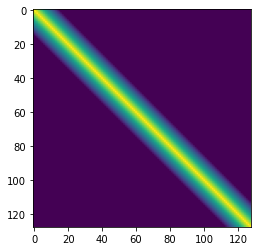

In [24]:
l = 30
corr = np.linspace(0,1,int(l/2)+1)
corr = np.hstack((corr,np.flipud(corr[:-1])))
indexes = np.linspace(-l/2,l/2,l+1,dtype=int)
corrmat = diags(corr, indexes, shape=(dim,dim)).toarray()

plt.imshow(corrmat)

Set new prior and plot a few samples:

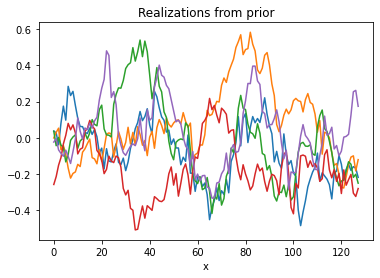

In [26]:
IP.prior = Gaussian(np.zeros(dim), prior_std, corrmat, name="x")

# Plot samples from prior
IP.prior.sample(5).plot() 
plt.title('Realizations from prior'); plt.show()

We have already updated the "prior" attribute of the IP, so we are ready to solve for the MAP and sample:

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct MAP of Gaussian posterior. Only works for small-scale problems with dim<=2000.


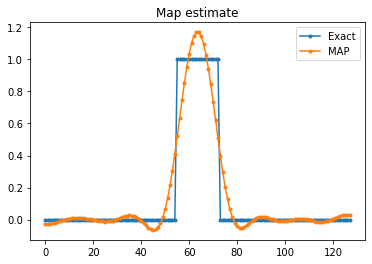

In [27]:
x_MAP_corr = IP.MAP()

# Plot
plt.plot(phantom,'.-')
plt.plot(x_MAP_corr,'.-')
plt.title("Map estimate")
plt.legend(["Exact","MAP"])
plt.show()

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct sampling of Gaussian posterior. Only works for small-scale problems with dim<=2000.
 Sample 5000 / 5000
Elapsed time: 0.11899614334106445


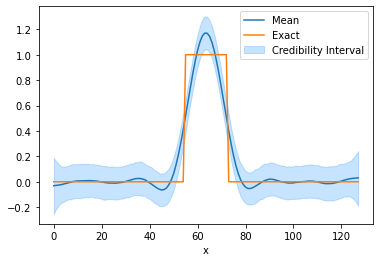

In [28]:
result_corr = IP.sample_posterior(Ns)

# plot mean + 95% of samples
result_corr.plot_ci(95, exact=phantom)

## 5. Change to a Cauchy prior

The correlated Gaussian gives a narrow credibility interval so was better than the IID Gaussian, but still cannot reproduce the sharp edges. We try a Cauchy prior.

In [29]:
scale = 2/dim
IP.prior = Cauchy_diff(np.zeros(dim), scale, 'neumann', name="x")

MAP for Cauchy.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using scipy.optimize.fmin_l_bfgs_b on negative log of Posterior
x0: ones vector
Optimizing with exact gradients


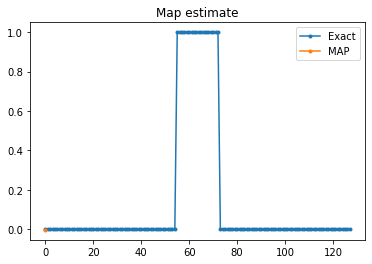

In [30]:
x_MAP_cau = IP.MAP()

# Plot
plt.plot(phantom,'.-')
plt.plot(x_MAP_cau[0],'.-')
plt.title("Map estimate")
plt.legend(["Exact","MAP"])
plt.show()

Sampling of posterior for Cauchy. Different sampling method than Gaussian and this is slower.

In [32]:
result_cau = IP.sample_posterior(Ns//10) #We dont need as many samples when the sampler is NUTS.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using No-U-Turn (NUTS) sampler
burn-in: 20%
Sample 600 / 600
Elapsed time: 61.81667709350586


Plot mean + 95% of samples

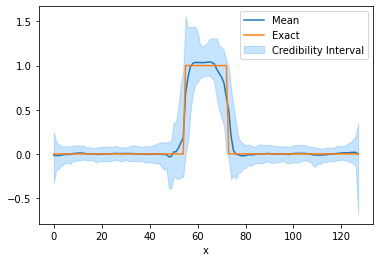

In [33]:
result_cau.plot_ci(95, exact=phantom)

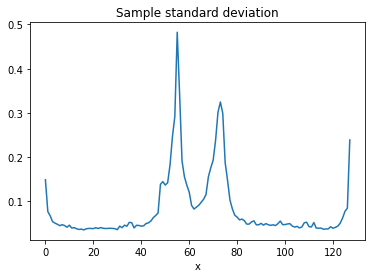

In [34]:
result_cau.plot_std()

## 6. Change to Laplace prior

Cauchy is known to be very edge-preserving but difficult to work with for example sample. Another edge-preserving prior is Laplace which typically is more well-behaved but not quite as strongly edge-preserving

In [37]:
# Set up Laplace prior
loc = np.zeros(dim)
delta = 0.5
scale = delta*1/dim
IP.prior = Laplace_diff(loc, scale, 'zero', name="x")

This runs yet another sampler

In [38]:
result_lap = IP.sample_posterior(Ns//10)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Unadjusted Laplace Approximation sampler
burn-in: 20%
Sample 600 / 600
Elapsed time: 11.811054468154907


Then we can use the plotting methods such as of the credibility interval:

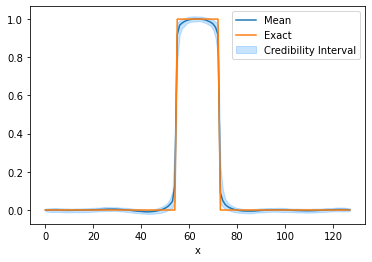

In [39]:
result_lap.plot_ci(95, exact=phantom)

Or std plot:

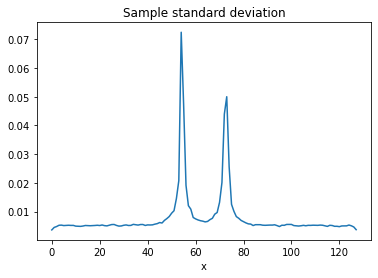

In [40]:
result_lap.plot_std()

## Some ideas to try out (warning: not tested!)
1. Change phantom to another of the options provided by the TestProblem.
2. Change phantom to be a sample from Gaussian, then do UQ with correct and incorrect choices of prior.
3. Play with parameter of priors for example Cauchy and Laplace to see if a better solution can be obtained.
3. Change noise/likelihood to scaledGaussian